# Project: Spotify Music Clustering with Unsupervised Machine Learning

In [1]:
# Importing Dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import set_config

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import spotipy
import pickle
import yaml

In [2]:
sns.set(font_scale = 1.5, style = "darkgrid", palette = "bright")
set_config(display = "diagram", transform_output = "pandas")
warnings.filterwarnings(action = "ignore")
plt.rcParams["figure.figsize"] = (12, 8)
pd.options.display.max_columns = None
np.random.seed(seed = 42)

Let's load the dataset.

In [3]:
# Loading the dataset from a CSV file
df = pd.read_csv(filepath_or_buffer = "../Data/spotify_music_data.csv")

# Asserting the number of observations with at least one unique value to be equal to zero
assert df.loc[df.isna().any(axis = 1)].shape[0] == 0

# Asserting the number of duplicate observations to be equal to zero
assert df.duplicated().sum() == 0

# Displaying the first five recods
df.head()

,singer,track,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Rihanna,Here I Go Again,0.681,0.611,-5.939,0.0770,0.000332,0.00193,0.120,0.637,83.463
1,Rihanna,Pose,0.685,0.852,-3.153,0.0846,0.181000,0.00135,0.147,0.770,145.918
2,Dua Lipa,Running,0.620,0.694,-3.739,0.0311,0.017800,0.00000,0.190,0.319,98.002
3,Halsey,Drive,0.571,0.585,-8.392,0.0494,0.239000,0.00016,0.133,0.291,113.973
4,Post Malone,Psycho,0.750,0.560,-8.094,0.1050,0.546000,0.00000,0.111,0.459,140.060


Let's drop the **singer** and **track** columns as we are going to use only numeric features.

In [4]:
# Creating a data frame of independent features
X = df.drop(columns = ["singer", "track"])

# Displaying the first five records
X.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.681,0.611,-5.939,0.0770,0.000332,0.00193,0.120,0.637,83.463
1,0.685,0.852,-3.153,0.0846,0.181000,0.00135,0.147,0.770,145.918
2,0.620,0.694,-3.739,0.0311,0.017800,0.00000,0.190,0.319,98.002
3,0.571,0.585,-8.392,0.0494,0.239000,0.00016,0.133,0.291,113.973
4,0.750,0.560,-8.094,0.1050,0.546000,0.00000,0.111,0.459,140.060


Let's calculate the inertia for different number of clusters and define the optimal number of clusters using **Elbow** method.

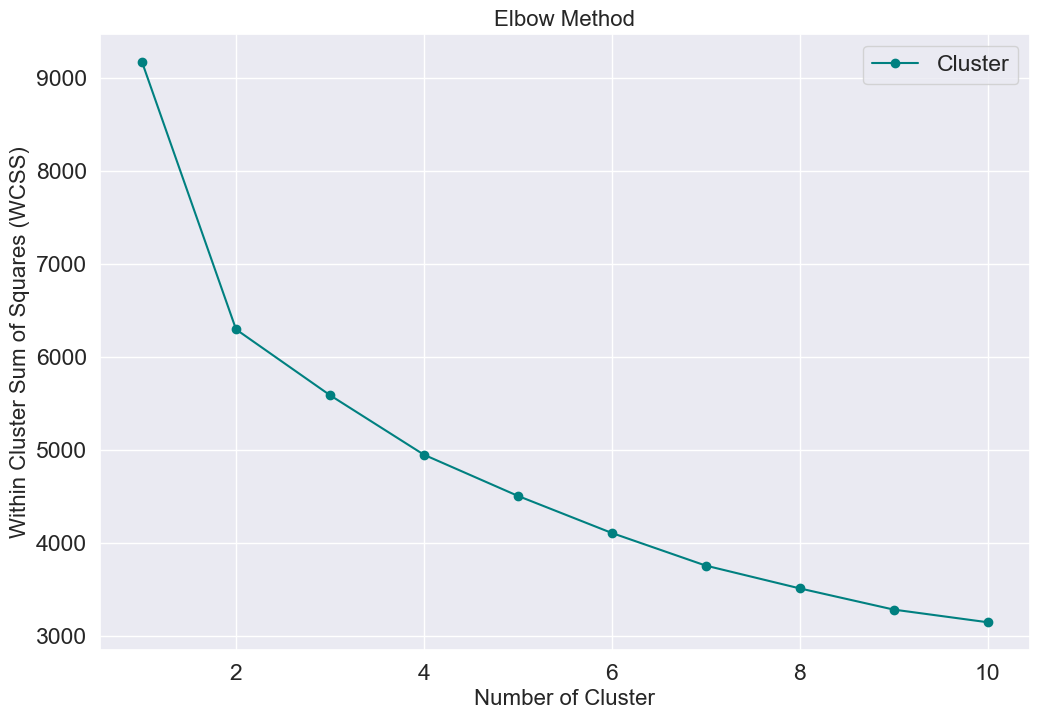

In [5]:
# Creating an empty list to store inertia
WCSS = []

# Creating a list of the number of clusters
n_clusters = list(range(1, 11))

# Looping through each integer
for i in n_clusters:
    # Building a model using KMeans algorithm
    model = Pipeline(steps = [("imputer", SimpleImputer(strategy = "constant", fill_value = 0)),
                              ("scaler", StandardScaler()),
                              ("algorithm", KMeans(n_clusters = i, random_state = 42))])
    
    # Fitting the features to the clustering pipeline
    model.fit(X = X)
    
    # Calculating the inertia
    inertia = model[-1].inertia_
    
    # Appending the inertia to the list
    WCSS.append(inertia)
    
# Defining the number of clusters using Elbow method
plt.plot(n_clusters, WCSS, marker = "o", c = "teal", label = "Cluster")
plt.title(label = "Elbow Method", fontsize = 16)
plt.ylabel(ylabel = "Within Cluster Sum of Squares (WCSS)", fontsize = 16)
plt.xlabel(xlabel = "Number of Cluster", fontsize = 16)
plt.legend(loc = "upper right")
plt.show()

Based on **Elbow** method, we can categorize tracks either into two or three distinct clusters. Let's build a clustering pipeline, predict the clusters and display the first five records.

In [6]:
# Building a clustering pipeline
pipe = Pipeline(steps = [("imputer", SimpleImputer(strategy = "constant", fill_value = 0)),
                         ("scaler", StandardScaler()),
                         ("algorithm", KMeans(n_clusters = 3, random_state = 42))])

# Fitting the features to the pipeline
df["cluster"] = pipe.fit_predict(X = X)

# Displaying the first five records
df.head()

,singer,track,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,Rihanna,Here I Go Again,0.681,0.611,-5.939,0.0770,0.000332,0.00193,0.120,0.637,83.463,2
1,Rihanna,Pose,0.685,0.852,-3.153,0.0846,0.181000,0.00135,0.147,0.770,145.918,2
2,Dua Lipa,Running,0.620,0.694,-3.739,0.0311,0.017800,0.00000,0.190,0.319,98.002,2
3,Halsey,Drive,0.571,0.585,-8.392,0.0494,0.239000,0.00016,0.133,0.291,113.973,0
4,Post Malone,Psycho,0.750,0.560,-8.094,0.1050,0.546000,0.00000,0.111,0.459,140.060,2


Let's calculate the average value of each feature based on each cluster.

In [7]:
# Let's aggregate features for each cluster for labelling
df.groupby(by = "cluster").mean().reset_index()

,cluster,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,0.539934,0.472780,-8.435611,0.065172,0.497873,0.110035,0.152985,0.291107,111.669086
1,1,0.333425,0.157651,-19.647470,0.051004,0.910872,0.820690,0.146660,0.135957,112.575396
2,2,0.657371,0.730457,-5.777177,0.089201,0.131520,0.109948,0.198102,0.559026,124.722182


Based on the aggregated data of each cluster, we can see clear distinctions in patterns. It is obvious that the tracks that belongs to the second cluster have the highest acousticness and instrumentalness whereas the ones in the third cluster have the highest energy, temp and danceability. However, the ones that belong to the first cluster are more like balanced in each feature. Based on the this information let's create a dictionary of labels for each cluster based on the aggregated data and map them. 

In [8]:
# Creating a dictionary of labels for each cluster based on the aggregated data
labels = {0: "Balanced", 1: "Acoustic", 2: "Energetic"}

# Mapping the labels to the corresponding clusters
df.cluster = df.cluster.map(arg = labels)

# Displaying the first five records
df.head()

,singer,track,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,Rihanna,Here I Go Again,0.681,0.611,-5.939,0.0770,0.000332,0.00193,0.120,0.637,83.463,Energetic
1,Rihanna,Pose,0.685,0.852,-3.153,0.0846,0.181000,0.00135,0.147,0.770,145.918,Energetic
2,Dua Lipa,Running,0.620,0.694,-3.739,0.0311,0.017800,0.00000,0.190,0.319,98.002,Energetic
3,Halsey,Drive,0.571,0.585,-8.392,0.0494,0.239000,0.00016,0.133,0.291,113.973,Balanced
4,Post Malone,Psycho,0.750,0.560,-8.094,0.1050,0.546000,0.00000,0.111,0.459,140.060,Energetic


Let's visualize the clusters by count.

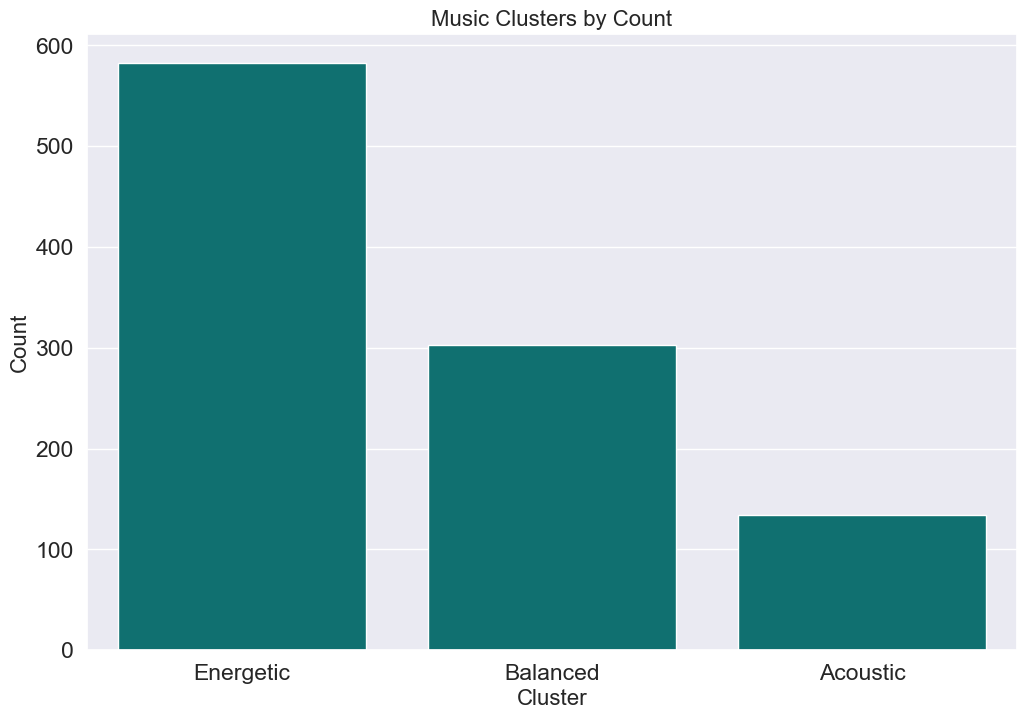

In [9]:
# Visualizing the clusters by count
sns.countplot(data = df, x = "cluster", color = "teal")
plt.title(label = "Music Clusters by Count", fontsize = 16)
plt.xlabel(xlabel = "Cluster", fontsize = 16)
plt.ylabel(ylabel = "Count", fontsize = 16)
plt.show()

Let's display the proportion of clusters to all tracks.

In [10]:
# Displaying the proportion of clusters
df.cluster.value_counts(normalize = True)

Energetic    0.571148
Balanced     0.297350
Acoustic     0.131501
Name: cluster, dtype: float64

Let's load the configuration file.

In [11]:
# Loading the configuration file
with open(file = "../Configuration/config.yml") as yaml_file:
    config = yaml.safe_load(stream = yaml_file)

Let's extract the credentials for **Spotify API**.

In [12]:
# Extracting the client secret
sp_client_secret = config.get("client_secret")    
    
# Extracting the client ID
sp_client_id = config.get("client_id")

Let's define a function to make predictions.

In [13]:
# Defining a function to make prediction on a single track
def make_predictions(client_secret = sp_client_secret,
                     client_id = sp_client_id,
                     cluster_labels = labels,
                     pipeline = None,
                     data = None):
    """
    This is a function to make predictions.
    
    Args:
        client_secret: It is a credential used for Spotify API.
        client_id: A user ID for Spotify API.
        cluster_labels: A dictionary of labels.
        pipeline: A clustering pipeline to make predictions.
        data: A dictionary of singers and tracks.
        
    Returns:
        A Pandas data frame.
    """
    # Setting up the authentication with Spotify API
    sp_credentials_manager = spotipy.oauth2.SpotifyClientCredentials(client_id = client_id, client_secret = client_secret)

    # Instantiating the crawler
    sp = spotipy.Spotify(client_credentials_manager = sp_credentials_manager)
    
    # Creating a list of singers
    singers = list(data.keys())
    
    # Creating a list of tracks
    tracks = list(data.values())
    
    # Creating an empty list to store data frames
    audio_data = []
    
    # Looping through each singer and track
    for singer, track in zip(singers, tracks):
        # Defining the search query
        query = f"track:{track} artist:{singer}"

        # Running the query to extract data in JSON format
        search_results = sp.search(q = query, type = "track")
        
        try:
            # Extracting the track ID
            track_id = search_results.get("tracks").get("items")[0].get("id")

            # Extracting the audio features
            audio_features = sp.audio_features(tracks = track_id)[0]

            # Creating a dictionary to store relevant features
            audio_dict = {"singer": singer,
                          "track": track,
                          "danceability": audio_features.get("danceability"),
                          "energy": audio_features.get("energy"),
                          "loudness": audio_features.get("loudness"),
                          "speechiness": audio_features.get("speechiness"),
                          "acousticness": audio_features.get("acousticness"),
                          "instrumentalness": audio_features.get("instrumentalness"),
                          "liveness": audio_features.get("liveness"),
                          "valence": audio_features.get("valence"),
                          "tempo": audio_features.get("tempo")}

            # Converting dictionary to a data frame
            audio_df = pd.DataFrame(data = audio_dict, index = [0])

            # Appending data frame to the list
            audio_data.append(audio_df)
        except:
            # Passing to the next track in case an error occurs when extracting the audio features of a particular track
            pass
        
    # Concatenating the data frames
    concat_df = pd.concat(objs = audio_data, ignore_index = True)
    
    # Extracting the features
    audio_features = concat_df.drop(columns = ["singer", "track"])

    # Making predictions
    concat_df["cluster"] = pipeline.predict(X = audio_features)

    # Mapping the labels to clusters
    concat_df.cluster = concat_df.cluster.map(arg = cluster_labels)
    
    # Returning the data frame
    return concat_df

Let's create a dictionary of unseen singers and tracks and call the function to make predictions.

In [14]:
# Creating a dictionary of unseen singers and tracks to make predictions
unseen_data = {"Kordhell": "Murder In My Mind",
               "Ludovico Einaudi": "Due tramonti",
               "Jonah Kagen": "Broken"}

# Calling the function to make predictions on unseen data
predictions_df = make_predictions(pipeline = pipe, data = unseen_data)

# Displaying the predictions
predictions_df

,singer,track,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,Kordhell,Murder In My Mind,0.712,0.9720,-0.514,0.1120,0.00547,0.000071,0.128,0.5680,119.966,Energetic
1,Ludovico Einaudi,Due tramonti,0.199,0.0618,-22.286,0.0470,0.97000,0.864000,0.111,0.0687,119.842,Acoustic
2,Jonah Kagen,Broken,0.501,0.3480,-11.938,0.0579,0.50100,0.000002,0.106,0.2760,83.527,Balanced


Let's save the model as a pickle object.

In [15]:
# Saving the model as a pickle object
with open(file = "../Models/spotify_model.pickle", mode = "wb") as pickled_model:
    pickle.dump(obj = pipe, file = pickled_model)